In [6]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH_NUM = lambda x: 'experiments-final{}/'.format(x)
DF_PATH = DF_PATH_NUM(3)

In [3]:
SURVEY_ZONE_MAPPING = {'30': (2, 2, 0), '22': (3, 1, 2), '2c': (2, 0, 0), '28': (2, 2, 1), '25': (3, 2, 1), '26': (3, 1, 1), '27': (3, 0, 1), '20': (2, 2, 2), '21': (3, 2, 2), '1e': (3, 1, 2), '23': (3, 0, 2), '24': (2, 0, 1), '29': (3, 2, 1), '1a': (3, 1, 3), '0': (1, 0, 3), '3': (3, 1, 0), '2': (3, 2, 0), '5': (1, 0, 0), '1d': (3, 2, 2), '7': (2, 1, 1), '1f': (3, 0, 2), '9': (3, 1, 1), '8': (3, 2, 1), '3a': (3, 1, 3), '1c': (2, 0, 2), '4': (3, 0, 0), 'a': (3, 0, 1), '6': (1, 0, 1), '39': (3, 2, 3), '12': (1, 0, 2), '3b': (3, 0, 3), '1b': (3, 0, 3), 'b': (1, 0, 2), '13': (1, 0, 2), 'd': (3, 2, 2), '11': (1, 0, 3), '10': (1, 0, 3), 'c': (2, 1, 2), '38': (2, 0, 3), '15': (1, 0, 1), '14': (1, 0, 1), '17': (1, 0, 0), 'f': (3, 0, 2), '19': (3, 2, 3), '32': (3, 1, 0), '31': (3, 2, 0), '16': (1, 0, 0), '37': (3, 0, 3), '36': (3, 1, 3), '35': (3, 2, 3), '34': (2, 1, 3), '2d': (3, 2, 0), '2e': (3, 1, 0), '2f': (3, 0, 0), '1': (2, 1, 0), '2a': (3, 1, 1), '2b': (3, 0, 1), '18': (2, 2, 3), '33': (3, 0, 0), 'e': (3, 1, 2)}

In [4]:
_demands = [
    450,
    900,
    (450, 900),
    (900, 1800)
]

_weights = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.5, 0.5, 0),
    (0, 0.5, 0.5),
    (0.5, 0, 0.5),
    (0.33, 0.33, 0.33),
    (0, 0, 0)
]

_model_type = {
    (1, 0, 0): 'Delay priority',
    (0, 1, 0): 'Throughput priority',
    (0, 0, 1): 'Flow priority',
    (0.5, 0.5, 0): 'Delay-Throughput priority',
    (0, 0.5, 0.5): 'Throughput-Flow priority',
    (0.5, 0, 0.5): 'Delay-Flow priority',
    (0.33, 0.33, 0.33): 'Equal priority',
    (0, 0, 0): 'Parent model',
}

cols = [
    'Delay priority',
    'Throughput priority',
    'Flow priority',
    'Delay-Throughput priority',
    'Throughput-Flow priority',
    'Delay-Flow priority',
    'Equal priority',
    'Parent model'
]

## Loading the entrance and exit columns

In [125]:
filename = DF_PATH + 'sim-results/result_d900_old.xls'
df_tmp = pd.read_excel(filename, sheet_name='CVCC').fillna(0).set_index('t')
df_tmp.head()

,0x16 - exit0_lane3,0x10 - exit3_lane3,0x1 - approach0_lane2,0x2 - approach0_lane2,0x3 - approach0_lane2,0x4 - approach0_lane2,0x28 - approach1_lane3,0x29 - approach1_lane3,0x2a - approach1_lane3,0x2b - approach1_lane3,...,0x37 - approach3_lane2,0x15 - exit1_lane1,0xc - approach2_lane2,0xd - approach2_lane2,0xe - approach2_lane2,0xf - approach2_lane2,0x24 - approach1_lane1,0x25 - approach1_lane1,0x26 - approach1_lane1,0x27 - approach1_lane1
t,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
5,0,0,0,0,1,1,0,0,0,1,...,1,0,0,1,1,2,0,0,0,0


In [126]:
# Filter out some of the columns

survey_zones = df_tmp.columns.values[:]

entrances = [x for x in survey_zones if 'approach' in x]
exits = [y for y in survey_zones if 'exit' in y]

print("{} approach zones, {} exit zones".format(len(entrances), len(exits)))

48 approach zones, 12 exit zones


In [127]:
reg_approach = re.compile('0x(\w+) - approach.*')
reg_exit = re.compile('0x(\w+) - exit.*')

entrances_rename = dict([
    (k, SURVEY_ZONE_MAPPING[reg_approach.match(k).group(1)])
    for k in entrances
])

exits_rename = dict([
    (k, SURVEY_ZONE_MAPPING[reg_exit.match(k).group(1)])
    for k in exits
])

## (TEST) Exploration of the CVCC sheet

In [128]:
df_cvcc = df_tmp.rename(columns=entrances_rename).rename(columns=exits_rename)

In [129]:
df_cvcc = df_cvcc.stack().reset_index().pivot_table(index='t', columns='level_1', values=0, aggfunc='sum')

In [130]:
cvcc_entrance = df_cvcc[[(3,0,0), (3,0,1), (3,0,2), (3,0,3)]].sum(axis=1)
cvcc_exit = df_cvcc[[(1,0,0), (1,0,1), (1,0,2), (1,0,3)]].sum(axis=1)

cvcc_tmp = pd.concat([cvcc_entrance, cvcc_exit], axis=1)
cvcc_tmp.columns = ['Entrance', 'Exit']

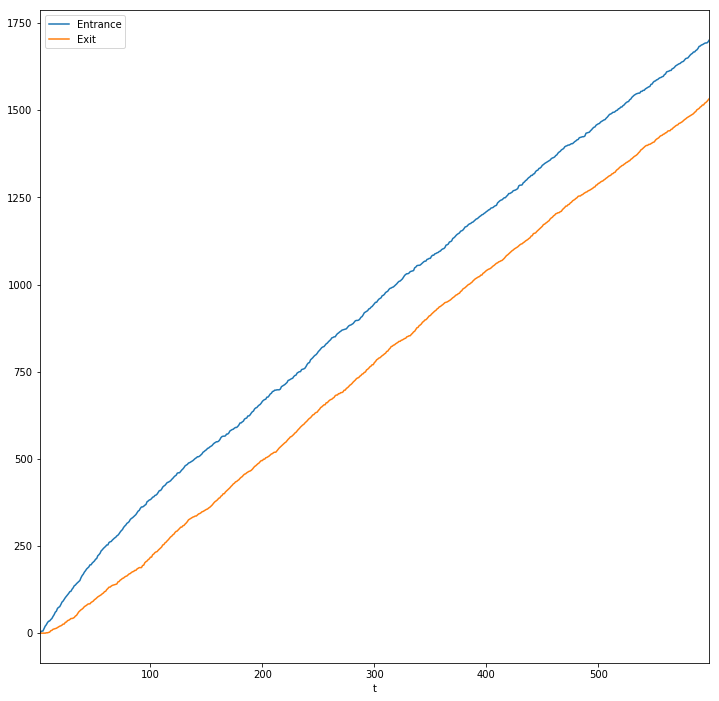

In [131]:
fig, ax = plt.subplots(figsize=(12,12))

cvcc_tmp.plot(ax=ax)